In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"]="TestProject"


In [3]:
# initialize the llm
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-20b",temperature=0.6)
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022681E82270>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022681E82E40>, model_name='openai/gpt-oss-20b', temperature=0.6, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:

class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [ ]:
## a graph with a tool call
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """ function that adds two numbers."""
    return a+b
tools=[add]
llm_with_tools = llm.bind_tools(tools)



In [6]:
# craete a state graaph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# building the graph
builder = StateGraph(State)

# add nodes
builder.add_node("chatbot_wtools", call_llm_model)
builder.add_node("tools", ToolNode(tools))  # <-- Change node name from "tool_node" to "tools"

# add edges
builder.add_edge(START, "chatbot_wtools")
builder.add_conditional_edges("chatbot_wtools", tools_condition)  # This expects a node named "tools"
builder.add_edge("tools", "chatbot_wtools")
# builder.add_edge("chatbot_wtools", END)

# compile the graph
graph = builder.compile()  # add checkpointer memory if needed

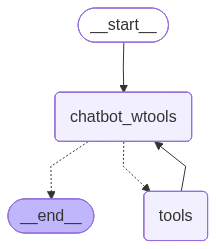

In [7]:
# display the graph
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
response = graph.invoke({"messages":"what is reinforcement learning"})
response["messages"][-1].content

"**Reinforcement Learning (RL)** is a branch of machine learning in which an *agent* learns to make decisions by interacting with an *environment* and receiving feedback in the form of *rewards* or penalties. Unlike supervised learning (where a model is trained on labeled input–output pairs) or unsupervised learning (where the model discovers structure in unlabeled data), RL is all about *action* and *temporal consequence*.\n\n---\n\n## Core Components\n\n| Symbol | Meaning | Example |\n|--------|---------|---------|\n| **Agent** | The learner / decision maker | A robot that learns to walk |\n| **Environment** | The world the agent interacts with | The terrain, obstacles, and physics |\n| **State (s)** | Current situation of the agent | Position & velocity of the robot |\n| **Action (a)** | Move the agent can take | Move left / right / jump |\n| **Reward (r)** | Immediate feedback after an action | +10 for reaching a goal, -1 for a collision |\n| **Policy (π)** | Strategy mapping state

In [9]:
response = graph.invoke({"messages":"what is 10 plus 5"})
response["messages"][-1].content

'15'

## the langsmith PROJECT EXECUTION trace
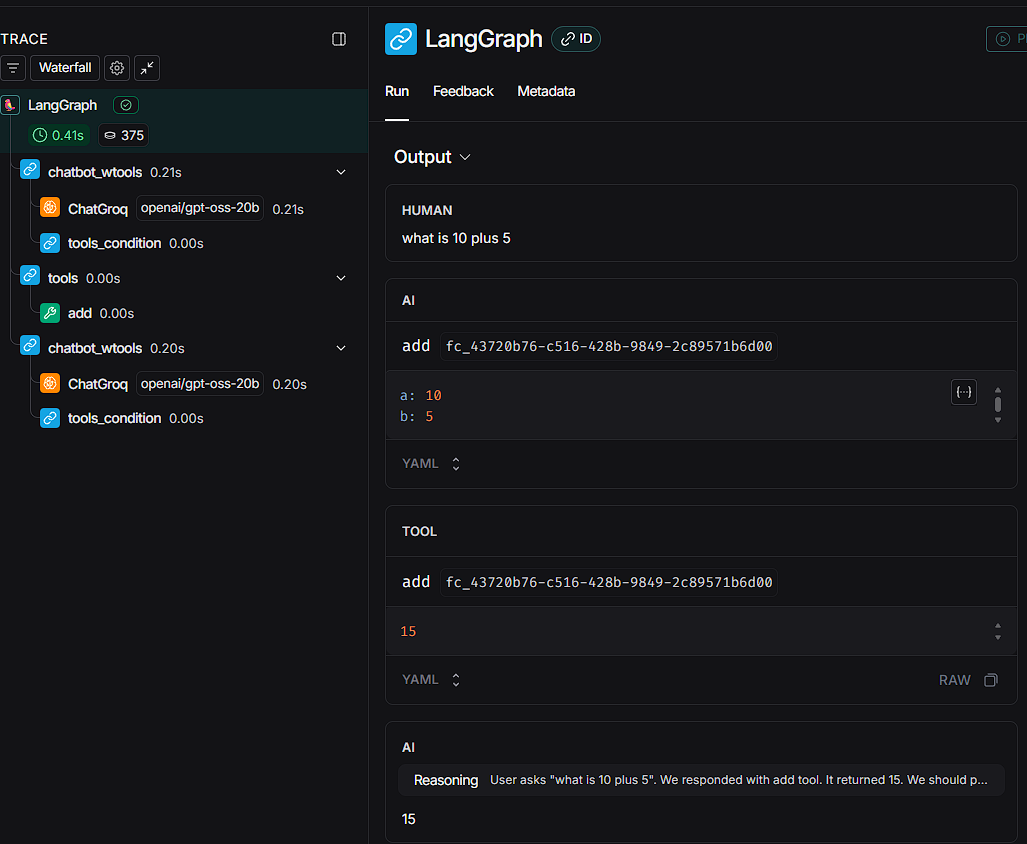